### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

import pandas as pd

### Loading the data

In [4]:
official_names = ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene']

In [5]:
components = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy.csv', skiprows=1, usecols=[0,1,2,4,5], #no menton
                      delimiter=',',dtype=float)

In [6]:
ppm_components = components[:,0]
components = components[:,1:]

In [7]:
mix = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy_bez_menthonu.csv', skiprows=1, usecols=range(2), 
                  delimiter=',',dtype=float)

In [8]:
ppm = mix[:,0]

In [9]:
mix = mix[:,1]

### Ground truth

In [10]:
#From email: 2.2449, 0.3269, 0.2533, 0.2651
r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
molar_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
print('Real proportions (molar):')
molar_proportions

Real proportions (molar):


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [11]:
protons = [34, 12, 16, 16]

In [12]:
real_visible_proportions = [mol_prop*prot for mol_prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [x/sum(real_visible_proportions) for x in real_visible_proportions]
print('Proportions that should be visible in mixture computed based on number of H:')
real_visible_proportions

Proportions that should be visible in mixture computed based on number of H:


[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

### Preprocessing

In [13]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [14]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [15]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

In [16]:
spectra_and_mixture = spectra + [mix]

<IPython.core.display.Javascript object>


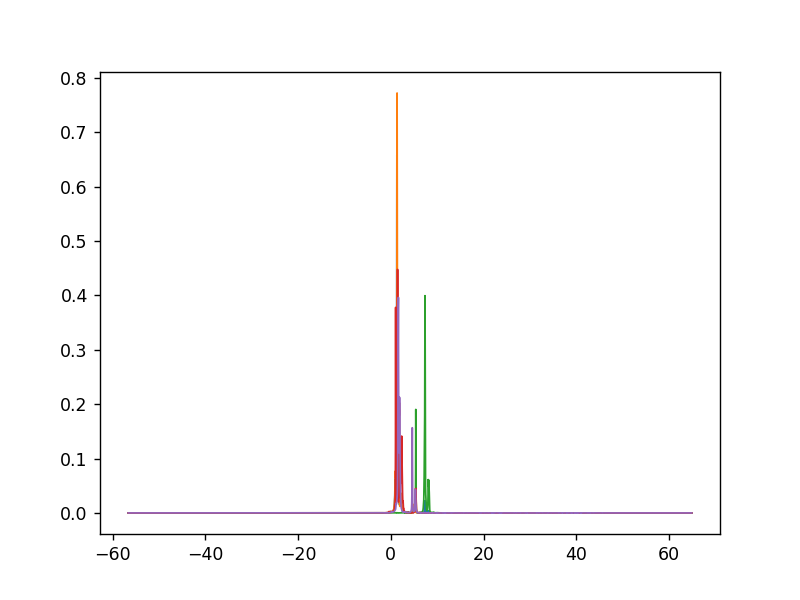

In [17]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)

### Additional preprocessing for this specific case

In [18]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.NMRSpectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [19]:
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, -1.5, 10.5)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

<IPython.core.display.Javascript object>


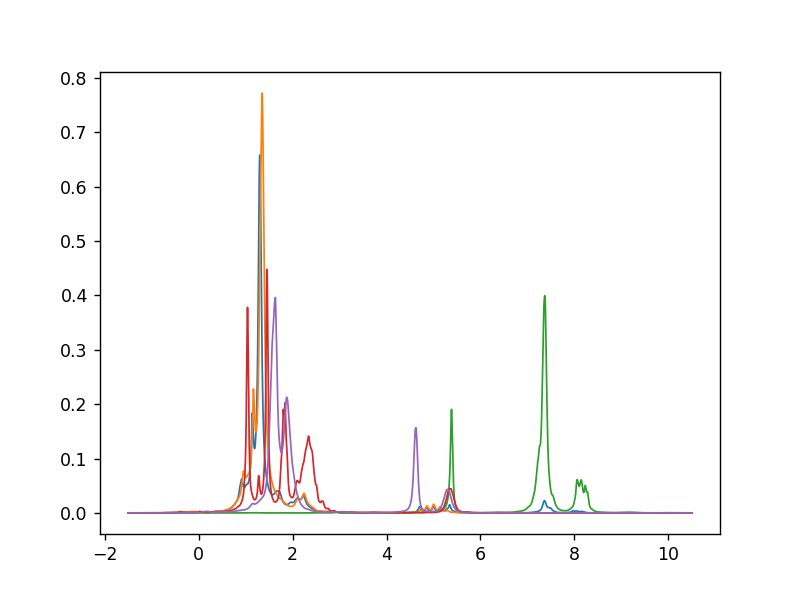

In [21]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)

### Preprocessing

In [23]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [24]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [25]:
spectra_and_mixture = spectra + [mix]

In [26]:
cma = common_mass_axis(spectra_and_mixture)

In [27]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [28]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [29]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [30]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [31]:
spectra_and_mixture = spectra + [mix]

In [32]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [35]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


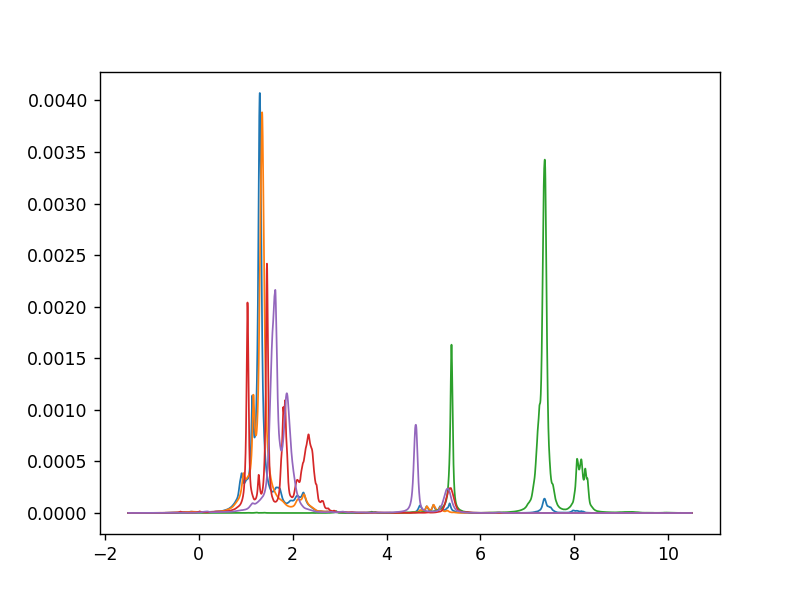

In [36]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)

### Finding best kappa

In [37]:
import time
import pandas as pd
import pulp

In [38]:
lower_limit = 0.01
upper_limit = 0.51
step = 0.01

In [40]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

In [41]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0,comp1,comp2,comp3])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [42]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)
# #first coordinate: kappa
# #second coordinate: kappa_prime

#### Visible proportions

In [39]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa
#second coordinate: kappa_prime

In [40]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [41]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Molar proportions

In [42]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [43]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [44]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [45]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Both

In [46]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [47]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [48]:
all_components_results_both.min().min()

0.0667316472908416

In [49]:
all_components_results_both[0.24000000000000002][0.37]

0.0667316472908416

### Saving preprocessed spectra

In [50]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')